In [20]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

from scripts.dataset_explorer import SODataSetExplorer
from scripts.tech_labeling import tech_labeling 

In [2]:
import plotly.express as px
import plotly
import plotly.io as pio
import plotly.graph_objects as go

In [3]:
import chart_studio
import chart_studio.plotly as py
import os

chart_studio_apikey = os.getenv('CHART_STUDIO_API_KEY')
chart_studio.tools.set_credentials_file(username='masharo', api_key=chart_studio_apikey)

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

### Load Dataset

In [5]:
df_explorer = SODataSetExplorer()

### Exploring Programming languages and Technologies

In [6]:
df_explorer.similar_columns(['language', 'tech',]);

2011
{'programming_languages',
 'programming_languages_other',
 'tech_products_own',
 'tech_products_own_other',
 'techn_related_purchases_last_year'}


2012
{'programming_languages',
 'programming_languages_other',
 'tech_products_own',
 'tech_products_own_other',
 'techn_related_purchases_last_year'}


2013
{'importance_opportunity_to_use_learn_new_technologies',
 'new_tech_interests',
 'programming_languages',
 'programming_languages_other',
 'tech_products_own',
 'tech_products_own_other',
 'techn_related_purchases_last_year',
 'time_per_week_technical_support'}


2014
{'new_tech_interests',
 'programming_languages',
 'programming_languages_other',
 'tech_products_own',
 'tech_products_own_other',
 'time_per_week_technical_support'}


2015
{'programming_languages',
 'programming_languages_other',
 'want_work_language',
 'want_work_language_other'}


2016
{'agree_tech',
 'important_newtech',
 'tech_do',
 'tech_want',
 'why_learn_new_tech'}


2017
{'assess_job_tech',
 'have_worked_la

* Rename feature into `programming_languages`

In [7]:
progr_lang_rename = {
    'tech_do': 'programming_languages',
    'have_worked_language': 'programming_languages',
    'language_worked_with': 'programming_languages',
}
df_explorer.rename_columns(progr_lang_rename)

* `programming_languages`. Multiple choice categorical features

* Merging feature `programming_languages` feature across years 

In [13]:
df_programming_languages = [
    df[['year', 'programming_languages']] for df in df_explorer.datasets.values() 
    if 'programming_languages' in df.columns.tolist()
]

concat_programming_languages = pd.concat(df_programming_languages, ignore_index=True)

In [14]:
concat_programming_languages.head()

,year,programming_languages
0,2011,JavaScript
1,2011,Java;SQL;C
2,2011,Java;JavaScript;SQL
3,2011,Java
4,2011,Java;JavaScript;CSS;PHP;SQL;C++;C;Perl


### Exploding programming languages feature
Two columns: `programming_languages` and `programming_languages_other`

In [15]:
concat_programming_languages['programming_languages'] = concat_programming_languages.programming_languages.str.lower().str.split('/|;')

In [16]:
df_explode = concat_programming_languages.explode('programming_languages')
df_explode['programming_languages'] = df_explode.programming_languages.str.strip()

In [17]:
df_explode.loc[df_explode.programming_languages.str.startswith('cloud', na=False), 'programming_languages'] = 'cloud'

In [18]:
df_explode.head()

,year,programming_languages
0,2011,javascript
1,2011,java
1,2011,sql
1,2011,c
2,2011,java


In [19]:
df_explode.shape

(2049496, 2)

### Languages and technologies labeling

In [21]:
df_explode['tech_type'] = df_explode.programming_languages.map(lambda x: tech_labeling.get(x, ''))

### Common languages evolution

In [22]:
languages_df = df_explode[df_explode.tech_type.str.contains('language')]
langs_year = languages_df.groupby(['year', 'programming_languages']).agg({'programming_languages': 'count'})
langs_year['Percentage'] = langs_year.groupby(level=0).programming_languages.apply(lambda x: x / float(x.sum())).round(4)
langs_year.columns = ['Count', 'Percentage']
display(langs_year.head())

langs_year.index.names = ['Year','Language']
langs_year.reset_index(inplace=True)
langs_year.sort_values(['Year', 'Count'], ascending=True, inplace=True)

Count  Percentage
year programming_languages                   
2011 c                        741      0.0740
     c#                      1352      0.1350
     c++                      740      0.0739
     css                     1356      0.1354
     java                     861      0.0860

In [25]:
langs_year.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 222 entries, 6 to 206
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Year        222 non-null    object 
 1   Language    222 non-null    object 
 2   Count       222 non-null    int64  
 3   Percentage  222 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 8.7+ KB


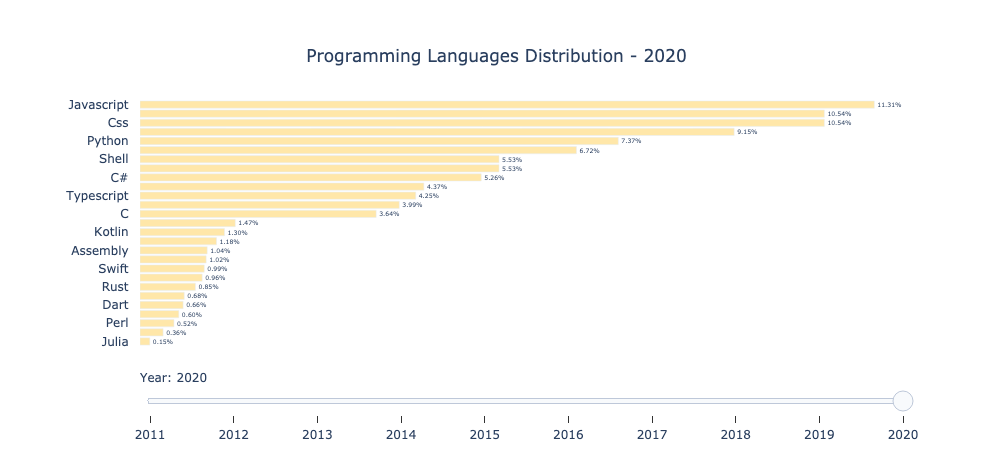

In [26]:
dataset_years = list(range(2011,2021))

dfs = {}
for year in dataset_years:
    dfs[year] = langs_year[langs_year['Year']==str(year)]

start_index = 9    

data=[
    go.Bar(
        x=dfs[year]['Count'], 
        y=dfs[year]['Language'].str.title(), 
        orientation='h',
        text=dfs[year]['Percentage'],
        texttemplate='%{text:.2%}',
        textposition='outside', 
        insidetextanchor='end',
        visible = False,
        name=str(year),
        marker=dict(
            color='rgb(255, 231, 169)',
        ),
        # formating text: https://github.com/d3/d3-format
        hovertemplate = 
            '<b>%{y}</b><br><br>'+
            'Count: %{x:.d} <br>'+ 
            'Percentage: %{text:.2%}<br>'+
            "<extra></extra>"
    )
    for year in dataset_years
]
data[start_index]['visible'] = True

steps = []
for i, year in enumerate(dataset_years):
    step = dict(
        # Update method allows us to update both trace and layout properties
        method = 'update',  
        args = [
            # Make the ith trace visible
            {'visible': [t == i for t in range(len(data))]},
            # Set the title for the ith trace
            {'title.text': 'Programming Languages Distribution - %d' % year},
            {
                "frame": {"duration": 300, "redraw": True},
                 "mode": "immediate",
                 "transition": {"duration": 500}
            }
        ],
        label=str(year)
    )
    steps.append(step)
    
sliders = [go.layout.Slider(
    active = start_index,
    currentvalue = {"prefix": "Year: "},
    transition={"duration": 300, "easing": "cubic-in-out"},
    steps = steps,
)]

layout = go.Layout(
    sliders=sliders,
    title={
        'text': "Programming Languages Distribution - 2020",
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    margin= {'l': 140}, # fix slider selector to overflow specified ticks
    plot_bgcolor='rgba(0,0,0,0)',
    xaxis={'visible': False,  'tickformat': "digit" },
    yaxis={'ticks': "outside", 'tickcolor':'white', 'ticklen': 8, }#'visible': False},
)

fig = go.Figure(data=data, layout=layout)

fig.show()

In [21]:
py.plot(fig, filename = 'stack-overflow-languages-over-year')

'https://plotly.com/~masharo/56/'